#### Showcase its capabilities

In [105]:
from autoencoders import AutoEncoder
import tinygrad
from tinygrad import Tensor
from tinygrad.dtype import dtypes
import numpy as np
from tqdm import tqdm

In [106]:
from tinygrad.helpers import fetch
import gzip

# taken from tinygrad.extra.datasets:
def fetch_mnist(tensors=False):
  parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
  BASE_URL = "https://storage.googleapis.com/cvdf-datasets/mnist/"   # http://yann.lecun.com/exdb/mnist/ lacks https
  X_train = parse(fetch(f"{BASE_URL}train-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_train = parse(fetch(f"{BASE_URL}train-labels-idx1-ubyte.gz"))[8:].astype(np.int8)
  X_test = parse(fetch(f"{BASE_URL}t10k-images-idx3-ubyte.gz"))[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_test = parse(fetch(f"{BASE_URL}t10k-labels-idx1-ubyte.gz"))[8:].astype(np.int8)
  if tensors: return Tensor(X_train).reshape(-1, 1, 28, 28), Tensor(Y_train), Tensor(X_test).reshape(-1, 1, 28, 28), Tensor(Y_test)
  else: return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = fetch_mnist()
X_train, X_test = X_train/255.0, X_test/255.0


In [107]:
import matplotlib.pyplot as plt

def show_autoencoder(autoencoder, true_imgs: np.ndarray):
    plt.figure(figsize=(20, 8))

    for i, true_img in enumerate(true_imgs):
        processed_img = autoencoder(Tensor(true_img, requires_grad=False)).numpy()
        
        plt.subplot(2, 5, i+1)
        plt.imshow(true_img.reshape(28, 28))
        plt.title('True Image')

        plt.subplot(2, 5, i+6)
        plt.imshow(processed_img.reshape(28, 28))
        plt.title('Processed Image')

    plt.show()

In [108]:
autoencoder = AutoEncoder(784, 128, 10)
opt = tinygrad.nn.optim.SGD([layer.weight for layer in autoencoder.encoder.layers] + [layer.weight for layer in autoencoder.decoder.layers], lr=5e-4)

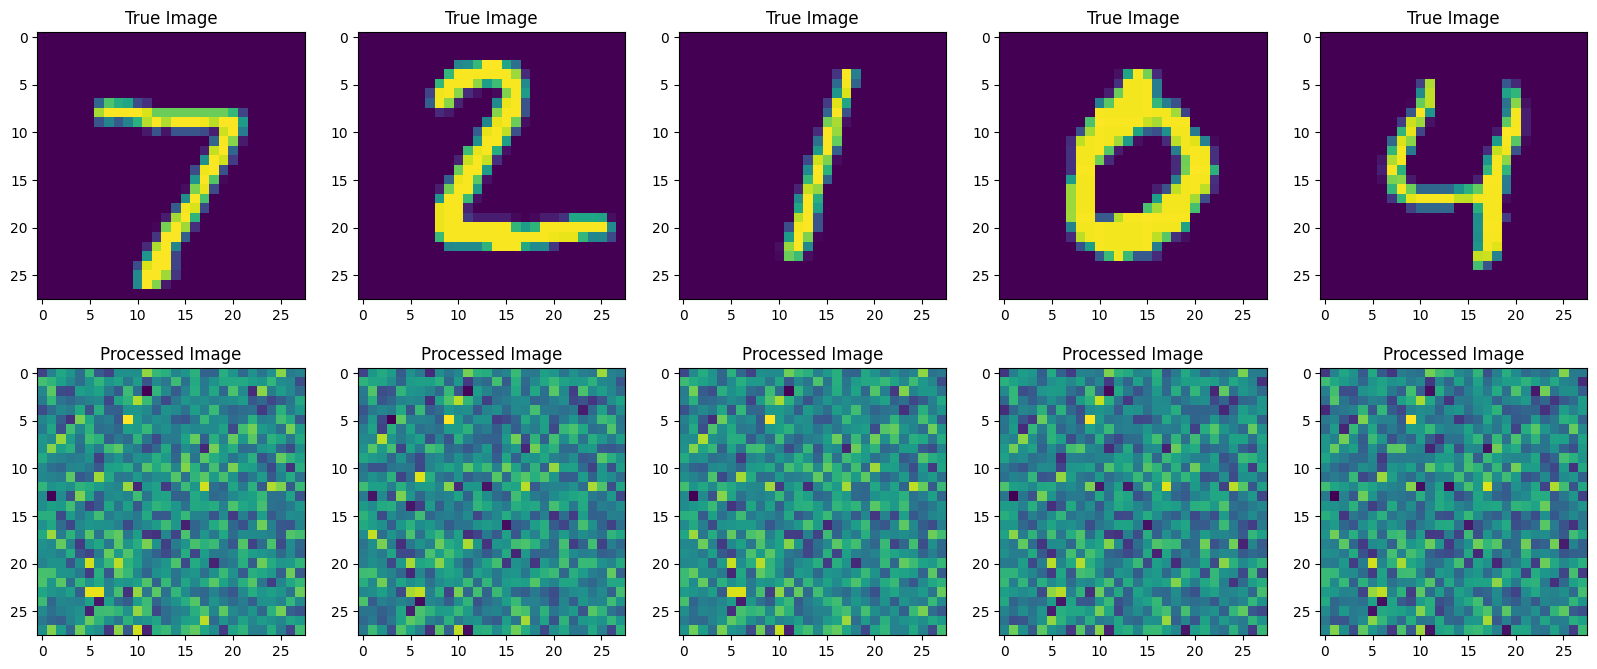

In [109]:
show_autoencoder(autoencoder, X_test[:5])

In [110]:
def sparse_categorical_crossentropy(x, y):
    z = ((x - y)**2).sum(axis=1).sum(axis=0)
    return z

In [111]:
steps = []
losses = []

with Tensor.train():
  for step in tqdm(range(50000)):
    # random sample a batch
    samp = np.random.randint(0, X_train.shape[0], size=(16))
    batch = Tensor(X_train[samp], requires_grad=False)
    labels = Tensor(X_train[samp])

    out = autoencoder(batch)
    loss = sparse_categorical_crossentropy(out, labels)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 100 == 0:
      steps.append(step)
      losses.append(loss.numpy())

100%|██████████| 50000/50000 [05:07<00:00, 162.50it/s]


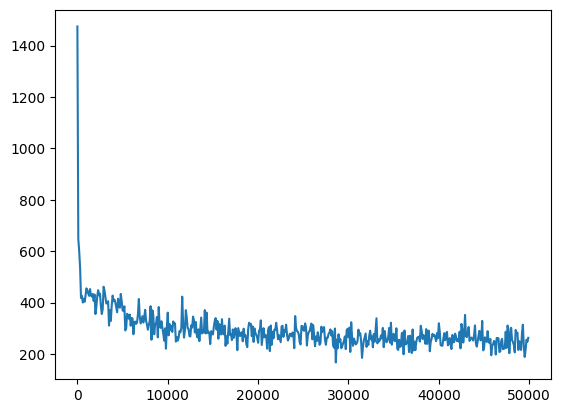

In [112]:
plt.plot(steps, losses)

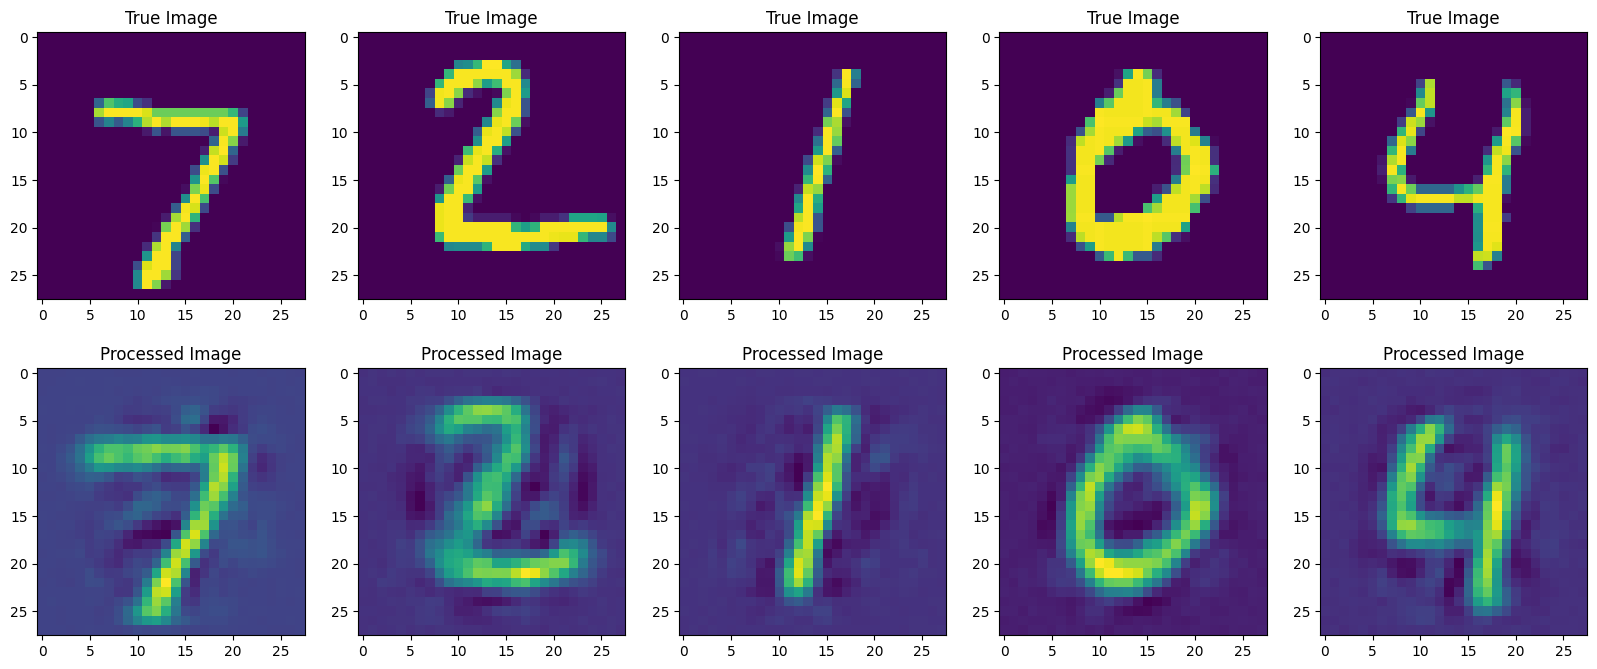

In [113]:
show_autoencoder(autoencoder, X_test[:5])